In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import AutoTokenizer, EsmForMaskedLM, AutoModel

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score
import umap

from tqdm import tqdm

### Initial Analysis
### Load PiNUI human data

In [2]:
data = pd.read_csv("./data/PiNUI-human.csv")
data.head()

,seqA,seqB,interaction
0,MKRRASDRGAGETSARAKALGSGISGNNAKRAGPFILGPRLGNSPV...,MAASAARGAAALRRSINQPVAFVRRIPWTAASSQLKEHFAQFGHVR...,1
1,MEAPSGSEPGGDGAGDCAHPDPRAPGAAAPSSGPGPCAAARESERQ...,MKLFHTADWHLGKLVHGVYMTEDQKIVLDQFVQAVEEEKPDAVIIA...,1
2,MDQNSVPEKAQNEADTNNADRFFRSHSSPPHHRPGHSRALHHYELH...,MTHCCSPCCQPTCCRTTCWQPTTVTTCSSTPCCQPSCCVSSCCQPC...,1
3,MFADLDYDIEEDKLGIPTVPGKVTLQKDAQNLIGISIGGGAQYCPC...,MARTLRPSPLCPGGGKAQLSSASLLGAGLLLQPPTPPPLLLLLFPL...,1
4,MAEGNHRKKPLKVLESLGKDFLTGVLDNLVEQNVLNWKEEEKKKYY...,MASADSRRVADGGGAGGTFQPYLDTLRQELQQTDPTLLSVVVAVLA...,1


In [3]:
# Get the sequences
all_proteins = list(set(data['seqA']).union(set(data['seqB'])))
N = len(all_proteins)
N

30263

## Visualization

### 1. Visualizing basic distributions

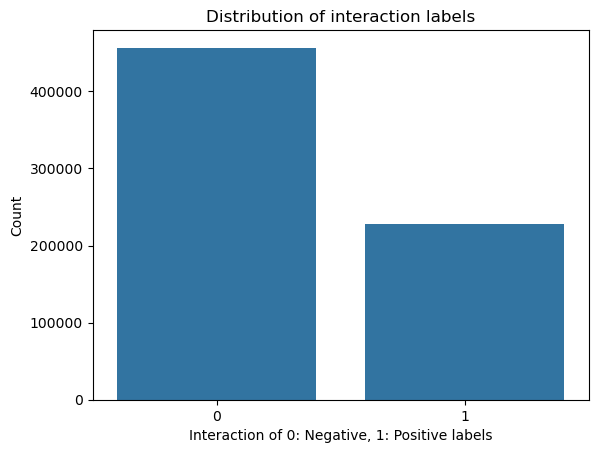

In [4]:
# Count plot for interaction labels
sns.countplot(x='interaction', data=data)
plt.title("Distribution of interaction labels")
plt.xlabel("Interaction of 0: Negative, 1: Positive labels")
plt.ylabel("Count")
plt.show()

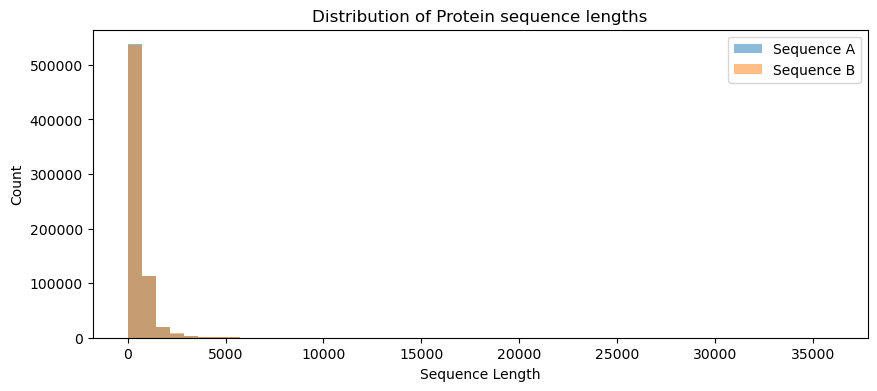

In [5]:
# Sequence length distribution
# Histogram of lenghts of proteins in Sequence-A and Sequence-B

data['seqA_length'] = data['seqA'].apply(len)
data['seqB_length'] = data['seqB'].apply(len)

plt.figure(figsize=(10, 4))
plt.hist(data['seqA_length'], bins=50, alpha=0.5, label='Sequence A')
plt.hist(data['seqB_length'], bins=50, alpha=0.5, label='Sequence B')
plt.title("Distribution of Protein sequence lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.legend()
plt.show()

### 2. Visualize the Embedding Space

In [6]:
# Getting the embeddings
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model.eval()

embeddings_list = []
labels = []

N_samples = 1000
for idx, row in data.head(N_samples).iterrows():
    # Concatenate the sequences with a delimiter
    pair_input = row['seqA'] + " [SEP] " + row['seqB']
    
    # Tokenize the pair to consistent max_length
    tokens = tokenizer(pair_input, return_tensors="pt", truncation=True, padding='max_length', max_length=1022)
    
    with torch.no_grad():
        outputs = esm_model(**tokens)
    
    # Pool the embeddings using mean pooling across tokens
    # outputs.last_hidden_state has shape (1, sequence_length, hidden_size)
    pooled_embedding = outputs.last_hidden_state.mean(dim=1)  # shape becomes (1, hidden_size)
    
    # Convert to numpy and store
    embeddings_list.append(pooled_embedding.squeeze(0).cpu().numpy())
    labels.append(row['interaction'])

embeddings_array = np.vstack(embeddings_list)
print(f"Shape of embeddigns: {embeddings_array.shape}")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Shape of embeddigns: (1000, 320)


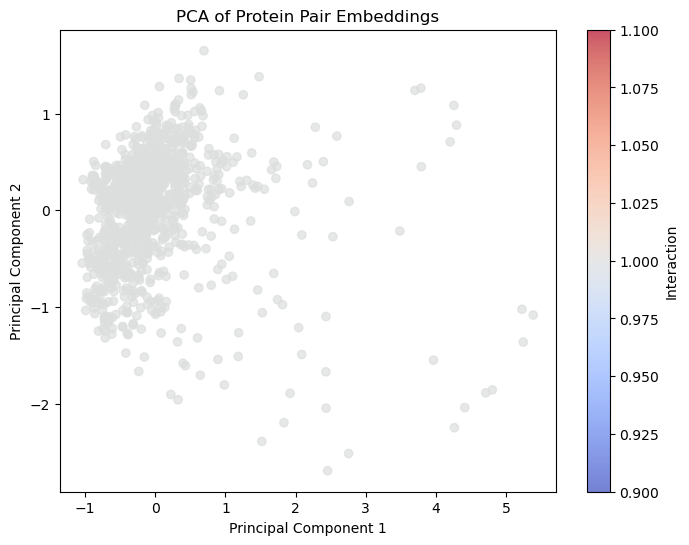

In [10]:
# Dimentionality reduction - PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=labels, cmap="coolwarm", alpha=0.7)
plt.title("PCA of Protein Pair Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Interaction")
plt.show()

t-SNE shape: (1000, 2)


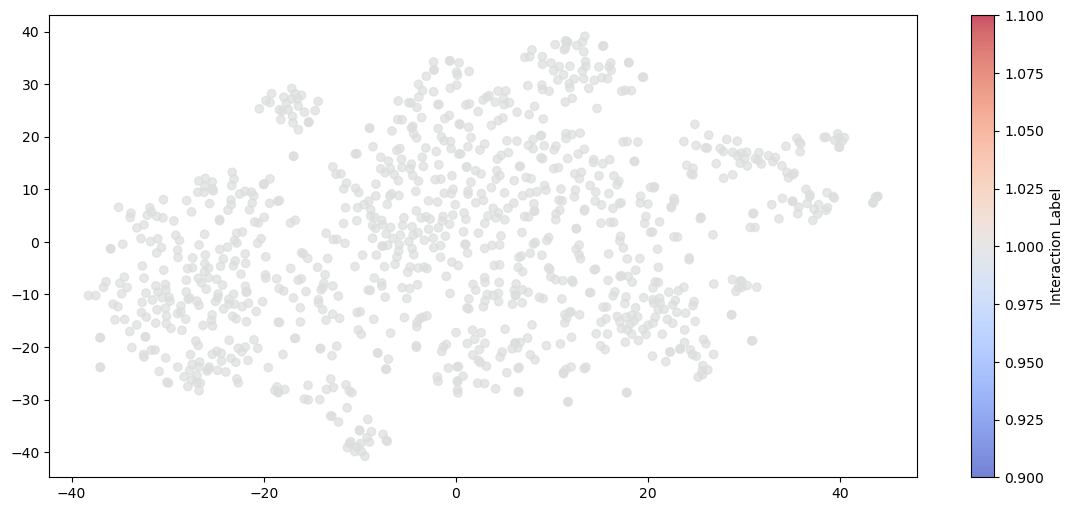

In [11]:
# Dimentionality reduction - tSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(embeddings_array)
print("t-SNE shape:", embeddings_tsne.shape)

plt.figure(figsize=(14, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Interaction Label")
plt.show()

/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (1000, 2)


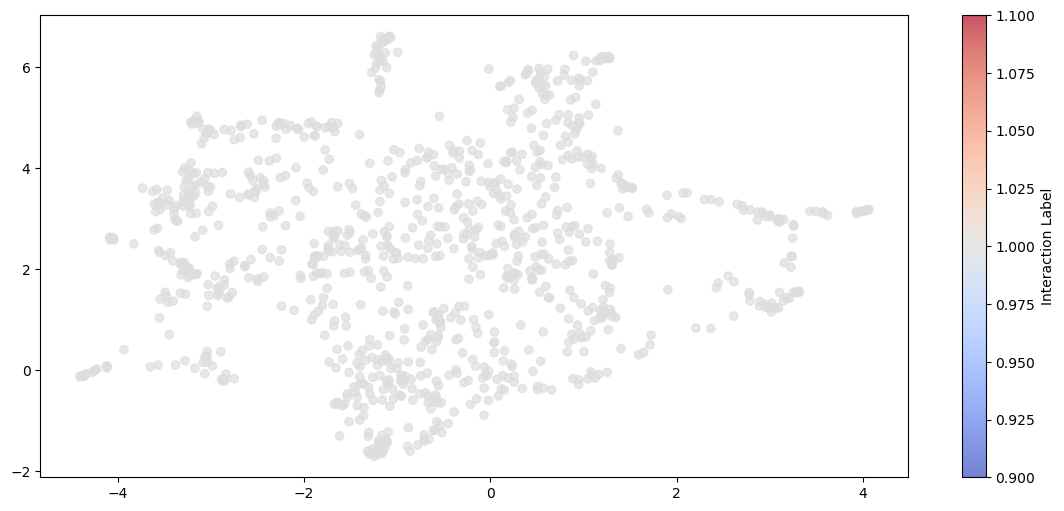

In [12]:
# Dimentionality reduction - UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = umap_reducer.fit_transform(embeddings_array)
print("UMAP shape:", embeddings_umap.shape)

plt.figure(figsize=(14, 6))
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Interaction Label")
plt.show()

### 3. Network Visualization

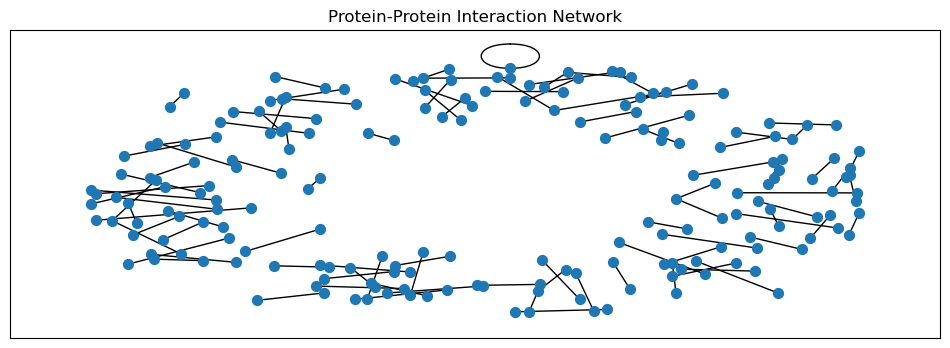

In [13]:
G = nx.from_pandas_edgelist(data[200000:200100], source='seqA', target='seqB', edge_attr=True)

plt.figure(figsize=(12,4))
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw_networkx(G, pos, node_size=50, font_size=8, with_labels=False)
plt.title("Protein-Protein Interaction Network")
plt.show()

## Dataset 

In [14]:
class PinuiDataset(Dataset):
    def __init__(self, data, esm_model, tokenizer, device='cpu'):
        self.seqA = list(data['seqA'])
        self.seqB = list(data['seqB'])
        self.interactions = list(data['interaction'])

        self.embeddings = []
        self.labels = []
        self.device = device
        esm_model.to(device)
        esm_model.eval()
        
        for seq1, seq2, interaction in zip(self.seqA, self.seqB, self.interactions):
            pair_input = seq1 + " [SEP] " + seq2
            tokens = tokenizer(pair_input, return_tensors="pt", truncation=True, padding='max_length', max_length=1022)
            tokens = {k: v.to(device) for k, v in tokens.items()}

            with torch.no_grad():
                outputs = esm_model(**tokens)
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze(0)

            self.embeddings.append(embedding.cpu())
            self.labels.append(torch.tensor(interaction, dtype=torch.float))

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

### Models

In [15]:
## MLP
class MLP(nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super().__init__()
        self.l1 = nn.Linear(input_dim, 1024)
        self.l2 = nn.Linear(1024, 256)
        self.l3 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.relu(self.l1(x))
        out = torch.relu(self.l2(out))
        out = self.dropout(out)
        out = self.l3(out)
        return out

In [16]:
# RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, data, hidden):
        combined = torch.cat((data, hidden), 1)
        hidden = torch.tanh(self.i2h(combined))
        output = self.i2o(combined)
        return output

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

### Training, Eval, Prediction and Vissualization functions

In [17]:
def train(model, train_loader, test_loader, optimizer, criterion, epochs, device):

        model.to(device)

        train_losses = []
        eval_losses = []
        train_accuracies = []
        eval_accuracies = []
        eval_precisions = []
        eval_auc = []

        for epoch in tqdm(range(epochs)):

            # Training
            model.train()
            running_loss = 0.0
            running_corrects = 0
            total_train_samples = 0

            for embeddings, targets in train_loader:
                embeddings = embeddings.to(device)
                targets = targets.to(device)
                optimizer.zero_grad()

                outputs = model(embeddings)
                loss = criterion(outputs.squeeze(), targets)
                loss.backward()
                optimizer.step()

                batch_size = embeddings.size(0)
                running_loss += loss.item() * batch_size
                probabilities = torch.sigmoid(outputs.squeeze())
                preds = (probabilities > 0.5).long()
                running_corrects += (preds == targets.long()).sum().item()
                total_train_samples += batch_size

            epoch_train_loss = running_loss / total_train_samples
            epoch_train_acc = running_corrects / total_train_samples
            train_losses.append(epoch_train_loss)
            train_accuracies.append(epoch_train_acc)

            # Evaluation
            model.eval()
            running_eval_loss = 0.0
            eval_corrects = 0
            total_eval_samples = 0
            
            all_preds = []
            all_targets = []
            all_probs = []

            with torch.no_grad():
                for embeddings, targets in test_loader:
                    embeddings = embeddings.to(device)
                    targets = targets.to(device)

                    outputs = model(embeddings)
                    loss = criterion(outputs.squeeze(), targets)

                    batch_size = embeddings.size(0)
                    running_eval_loss += loss.item() * batch_size
                
                    probabilities = torch.sigmoid(outputs.squeeze())
                    preds = (probabilities > 0.5).long()
                    eval_corrects += (preds == targets.long()).sum().item()
                    total_eval_samples += batch_size
                    
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
                    all_probs.extend(probabilities.cpu().numpy())

            epoch_eval_loss = running_eval_loss / total_eval_samples
            epoch_eval_acc = eval_corrects / total_eval_samples
            eval_losses.append(epoch_eval_loss)
            eval_accuracies.append(epoch_eval_acc)
            
            # Compute additional evaluation metrics
            precision = precision_score(all_targets, all_preds, zero_division=0)
            auc = roc_auc_score(all_targets, all_probs)
            eval_precisions.append(precision)
            eval_auc.append(auc)
            
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
            print(f"  Eval Loss: {epoch_eval_loss:.4f} | Eval Acc: {epoch_eval_acc:.4f} | Precision: {precision:.4f} | AUC: {auc:.4f}")
    
            metrics = {
                "train_losses": train_losses,
                "eval_losses": eval_losses,
                "train_accuracies": train_accuracies,
                "eval_accuracies": eval_accuracies,
                "eval_precisions": eval_precisions,
                "eval_auc": eval_auc,
            }
        
        return metrics
        
        

In [18]:
def evaluate(model, test_loader, criterion, device):
    model.to(device)

    model.eval()
    total_eval_loss = 0.0
    all_preds = []
    all_targets = []
    all_probabilities = []

    with torch.no_grad():
        for embeddings, targets in test_loader:
            embeddings = embeddings.to(device)
            targets = targets.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs.squeeze(), targets)
            total_eval_loss += loss.item() * embeddings.size(0)

            probabilities = torch.sigmoid(outputs.squeeze())
            preds = (probabilities > 0.5).long()
            
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())
            all_probabilities.append(probabilities.cpu())
    
    # Concatenate outputs across all batches
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_probabilities = torch.cat(all_probabilities).numpy()
    
    avg_loss = total_eval_loss / len(test_loader.dataset)
    
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy Score: {accuracy_score(all_targets, all_preds):.4f}")
    print(f"Precision Score: {precision_score(all_targets, all_preds):.4f}")
    print(f"AUC-ROC Score: {roc_auc_score(all_targets, all_probabilities):.4f}")


In [19]:
def predict(model, esm_model, seqA, seqB, device):
    model.to(device)
    esm_model.to(device)

    model.eval()
    pair_input = seqA + " [SEP] " + seqB
    tokens = tokenizer(pair_input, return_tensors="pt", truncation=True, padding='max_length', max_length=1022)
    tokens = {k: v.to(device) for k, v in tokens.items()}

    with torch.no_grad():
        outputs = esm_model(**tokens)
    
    # Pool the output over the token dimension to create a fixed-size embedding vector.
    # This gives a tensor of shape [1, hidden_size].
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze(0)

    output = model(embedding)
    prob = torch.sigmoid(output).item()

    pred = 1 if prob > 0.5 else 0

    return pred

In [20]:
def plot_metrics(metrics, num_epochs):
    epochs = range(1, num_epochs+1)
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics["train_losses"], label="Train Loss")
    plt.plot(epochs, metrics["eval_losses"], label="Eval Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics["train_accuracies"], label="Train Accuracy")
    plt.plot(epochs, metrics["eval_accuracies"], label="Eval Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics["eval_precisions"], label="Precision")
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.title("Precision over Epochs")
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics["eval_auc"], label="AUC-ROC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC-ROC")
    plt.title("AUC-ROC over Epochs")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Loading and Splitting the dataset

In [21]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

print("Loading data...")
data_model = pd.read_csv("./data/PiNUI-human.csv")
data_model = data[:500]

device = "cuda" if torch.cuda.is_available() else "cpu"
data_set = PinuiDataset(data_model, esm_model=esm_model, tokenizer=tokenizer)
train_len = int(len(data_set)*0.7)
train_set, test_set = random_split(data_set, [train_len, len(data_set)-train_len])

# Batch Size
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
print("Data Loaded.")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading data...
Data Loaded.


In [22]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
input_dim = esm_model.config.hidden_size 
print(esm_model.config.hidden_size)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


320


### MLP Model Training, Eval, Prediction and Visualization

In [23]:
epochs = 10
learning_rate = 1e-4
weight_decay = 1e-2

model = MLP(input_dim, 0.2)
# Loss function and Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

# Training
metrics = train(model, train_loader, test_loader, optimizer, criterion, epochs, device)

  0%|          | 0/10 [00:00<?, ?it/s]/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
 10%|█         | 1/10 [00:00<00:01,  5.66it/s]

Epoch 1/10
  Train Loss: 0.6367 | Train Acc: 0.8114
  Eval Loss: 0.5390 | Eval Acc: 1.0000 | Precision: 1.0000 | AUC: nan


/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
 40%|████      | 4/10 [00:00<00:00, 14.84it/s]/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 2/10
  Train Loss: 0.4681 | Train Acc: 1.0000
  Eval Loss: 0.3797 | Eval Acc: 1.0000 | Precision: 1.0000 | AUC: nan
Epoch 3/10
  Train Loss: 0.3102 | Train Acc: 1.0000
  Eval Loss: 0.2274 | Eval Acc: 1.0000 | Precision: 1.0000 | AUC: nan
Epoch 4/10
  Train Loss: 0.1718 | Train Acc: 1.0000
  Eval Loss: 0.1127 | Eval Acc: 1.0000 | Precision: 1.0000 | AUC: nan
Epoch 5/10
  Train Loss: 0.0821 | Train Acc: 1.0000
  Eval Loss: 0.0521 | Eval Acc: 1.0000 | Precision: 1.0000 | AUC: nan


/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
 60%|██████    | 6/10 [00:00<00:00, 16.56it/s]

Epoch 6/10
  Train Loss: 0.0384 | Train Acc: 1.0000
  Eval Loss: 0.0261 | Eval Acc: 1.0000 | Precision: 1.0000 | AUC: nan


/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
 90%|█████████ | 9/10 [00:00<00:00, 19.12it/s]/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
100%|██████████| 10/10 [00:00<00:00, 17.37it/s]

Epoch 7/10
  Train Loss: 0.0202 | Train Acc: 1.0000
  Eval Loss: 0.0150 | Eval Acc: 1.0000 | Precision: 1.0000 | AUC: nan
Epoch 8/10
  Train Loss: 0.0128 | Train Acc: 1.0000
  Eval Loss: 0.0098 | Eval Acc: 1.0000 | Precision: 1.0000 | AUC: nan
Epoch 9/10
  Train Loss: 0.0085 | Train Acc: 1.0000
  Eval Loss: 0.0069 | Eval Acc: 1.0000 | Precision: 1.0000 | AUC: nan
Epoch 10/10
  Train Loss: 0.0062 | Train Acc: 1.0000
  Eval Loss: 0.0052 | Eval Acc: 1.0000 | Precision: 1.0000 | AUC: nan


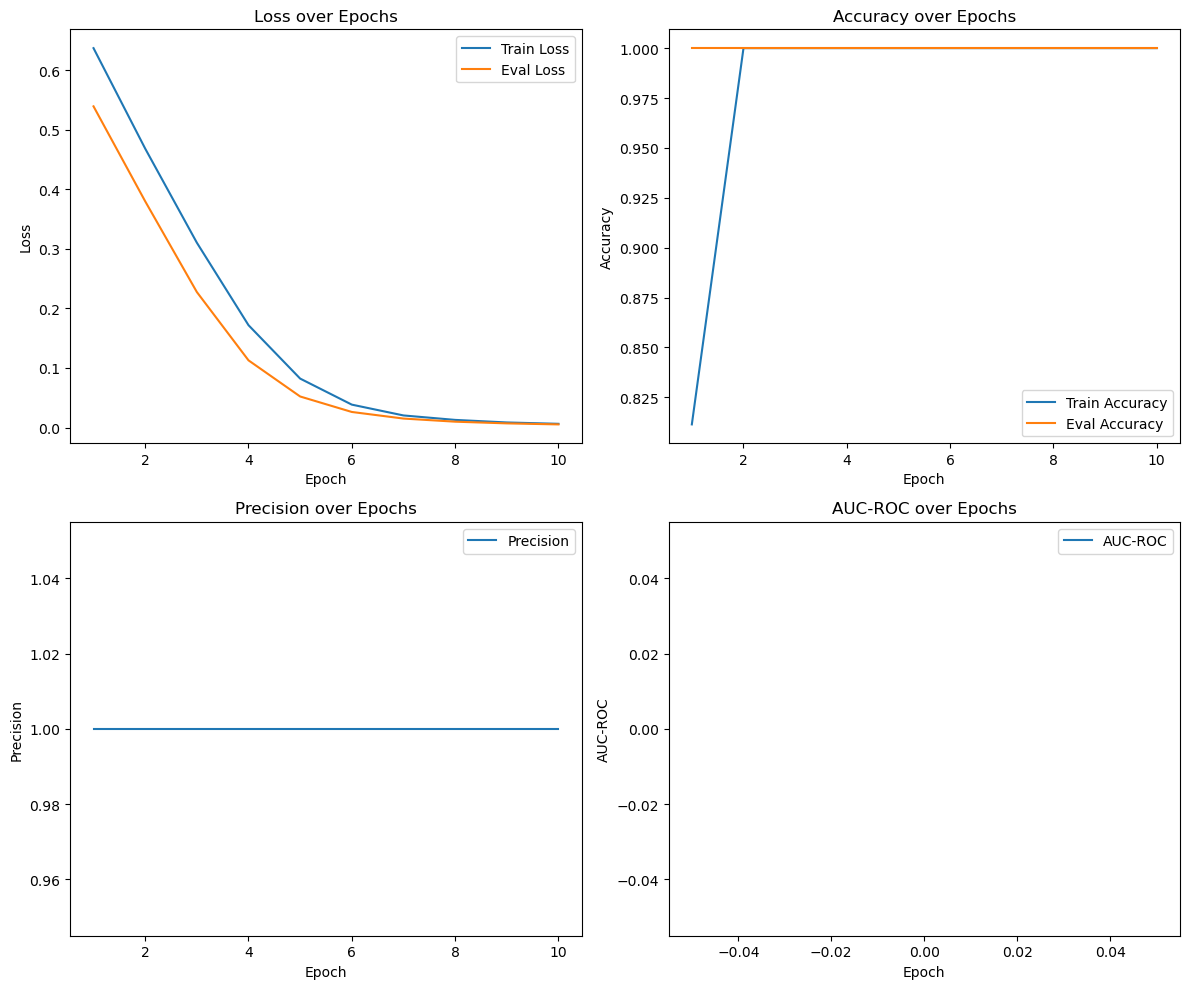

In [24]:
plot_metrics(metrics=metrics, num_epochs=epochs)

In [25]:
# Evaluate
evaluate(model, test_loader, criterion, device=device)

Average Loss: 0.0052
Accuracy Score: 1.0000
Precision Score: 1.0000
AUC-ROC Score: nan


/opt/anaconda3/envs/shiru/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [26]:
# Predicting
seqA = data['seqA'][228319]
seqB = data['seqB'][228319]
predict(model, esm_model, seqA, seqB, device=device)

1

## RNN Training, Eval, Prediction and Visualization

In [27]:
epochs = 10
learning_rate = 1e-4
weight_decay = 1e-2

input_dim = esm_model.config.hidden_size
hidden_size = input_dim // 2

model = RNN(input_dim, hidden_size, output_size=1)
# Loss function and Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

# Training
metrics = train(model, train_loader, test_loader, optimizer, criterion, epochs, device)

  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: RNN.forward() missing 1 required positional argument: 'hidden'

In [ ]:
plot_metrics(metrics=metrics, num_epochs=epochs)

In [ ]:
# Evaluate
evaluate(model, test_loader, criterion, device=device)

In [ ]:
# Predicting
seqA = data['seqA'][228319]
seqB = data['seqB'][228319]
predict(model, esm_model, seqA, seqB, device=device)